In [105]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import numpy as np
import torchvision.transforms.functional as F

In [106]:
torch.cuda.is_available()

True

In [107]:
batch_size = 4

In [108]:
data_dir = "C:\\Users\\nikit\\Desktop\\Учеба\\Магистратура\\Нейронные сети\\Лабы\\Lab1\\data"

In [109]:
class SquarePad():
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.Pad(padding).forward(image)

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((256, 256)),
    transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(data_dir,transform = transform)
test_size = int(len(dataset) * 0.3)
trainset, testset = torch.utils.data.random_split(dataset, lengths=[(len(dataset) - test_size), test_size], generator=torch.Generator().manual_seed(42))

In [110]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle = True, num_workers = 0, pin_memory = True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers = 0, pin_memory = True)

In [111]:
classes = ('apple', 'banana', 'orange')
print("Following classes are there : \n", classes)

Following classes are there : 
 ('apple', 'banana', 'orange')


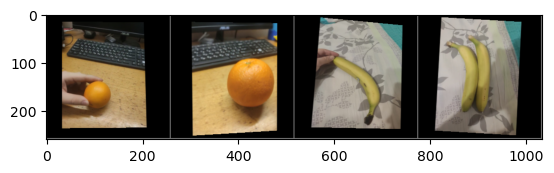

orange orange banana banana


In [112]:
import matplotlib.pyplot as plt
import numpy as np

# функция для показа изображения
def imshow(img):
    img = img  / 2  + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# получаем несколько случайных обучающих изображений
# subset_indices = [0, 1, 2, 3] # select your indices here as a list
# subset = torch.utils.data.Subset(trainset, subset_indices)
# trainloader_subset = torch.utils.data.DataLoader(subset, batch_size=batch_size, num_workers=0, shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)


# # показать изображения
imshow(torchvision.utils.make_grid(images))
# # показать лейблы изображений
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [113]:
import torch.nn as nn
import torch.nn.functional as F

# Инициализация модели
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5) # (in_channels, out_channels, kernel_size) Применяет 2D-свертку к входному сигналу, состоящему из нескольких входных плоскостей.
        self.pool = nn.MaxPool2d(2, 2) # (kernel_size, stride) Применяет MaxPool2D-объединение к входному сигналу, состоящему из нескольких входных плоскостей.
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)  
        self.fc1 = nn.Linear(32 * 28 * 28, 1024)# (in_features , out_features) Применяет линейное преобразование к входящим данным
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 3)

        self.dropout = nn.Dropout(0.25)

    # Это forward функция, которая определяет структуру сети.
    # Здесь мы принимаем только один вход, но можно использовать больше.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) #(input, start_dim) Сглаживает input путем преобразования его в одномерный тензор.
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
net = net.to(device)

In [114]:
import torch.optim as optim

#Критерии полезны для обучения нейронной сети. Учитывая входные данные и цель, они вычисляют градиент в соответствии с заданной функцией потерь
criterion = nn.CrossEntropyLoss()
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#lr - learning rate скорость обучения

# вычисляются градиенты функции потерь и затем суммы градиентов вычитаются из векторов весов для признаков (обычный градиент), при стохастическом выбирается случайный градиент


# loss.backward() вычисляет dloss/dx для каждого параметра x, который имеет requires_grad=True. Они накапливаются x.grad для каждого параметра x. 
# В псевдокоде:
# x.grad += dloss/dx

# optimizer.step обновляет значение x использования градиента x.grad. Например, оптимизатор SGD выполняет:

# x += -lr * x.grad
# optimizer.zero_grad() очищается x.grad для каждого параметра x в оптимизаторе. Важно вызвать это перед loss.backward(), иначе вы накопите градиенты от нескольких проходов.

In [115]:
for epoch in range(2):  # многократное прохождение по набору данных

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        inputs, labels = inputs.to(device), labels.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # накапливает градиент для каждого параметра х
        loss.backward()
        # обновляет градиент каждого параметра х
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        if i % 50 == 49:    # вывести каждые 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 49:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.122
[1,   100] loss: 1.121
[1,   150] loss: 1.116
[1,   200] loss: 1.107
[1,   250] loss: 1.086
[1,   300] loss: 1.054
[1,   350] loss: 1.016
[1,   400] loss: 0.906
[1,   450] loss: 0.948
[1,   500] loss: 0.933
[1,   550] loss: 0.835
[1,   600] loss: 0.878
[1,   650] loss: 0.864
[1,   700] loss: 0.730
[1,   750] loss: 0.803
[1,   800] loss: 0.672
[1,   850] loss: 0.744
[1,   900] loss: 0.668
[1,   950] loss: 0.586
[1,  1000] loss: 0.470
[1,  1050] loss: 0.639
[1,  1100] loss: 0.535
[1,  1150] loss: 0.527
[1,  1200] loss: 0.581
[1,  1250] loss: 0.470
[1,  1300] loss: 0.531
[1,  1350] loss: 0.616
[1,  1400] loss: 0.480
[1,  1450] loss: 0.491
[1,  1500] loss: 0.408
[1,  1550] loss: 0.374
[1,  1600] loss: 0.369
[1,  1650] loss: 0.455
[1,  1700] loss: 0.409
[1,  1750] loss: 0.338
[1,  1800] loss: 0.502
[1,  1850] loss: 0.344
[1,  1900] loss: 0.268
[1,  1950] loss: 0.391
[1,  2000] loss: 0.276
[1,  2050] loss: 0.317
[1,  2100] loss: 0.431
[1,  2150] loss: 0.460
[1,  2200] 

In [116]:
#Сохранение нашей модели
PATH = './Good_trans_fruit_cifar_netv.pth'
torch.save(net.state_dict(), PATH)

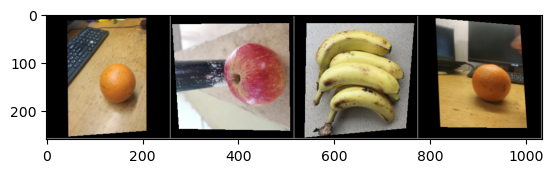

GroundTruth:  orange apple banana orange


In [125]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# вывод изображений
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [126]:
net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
images = images.to(device)


outputs = net(images)

In [128]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        images, labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        images, labels = images.to(device), labels.to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(images)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 4000 test images: {100 * correct // total} %')

Accuracy of the network on the 4000 test images: 95 %


In [129]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: apple is 94.9 %
Accuracy for class: banana is 94.1 %
Accuracy for class: orange is 98.3 %
